# Ensemble Methods

	• Bootstrap Aggregating (Bagging)
	• Random Forests and Feature Subsampling
	• Boosting: AdaBoost, XGBoost (Extreme Gradient Boosting)
	• Python: Implement AdaBoost with Weighted Errors


Test Point Predictions:
Point [2.5 2.5]: Predicted Class 0
Point [3.5 3.5]: Predicted Class 1
Point [4.5 4.5]: Predicted Class 1


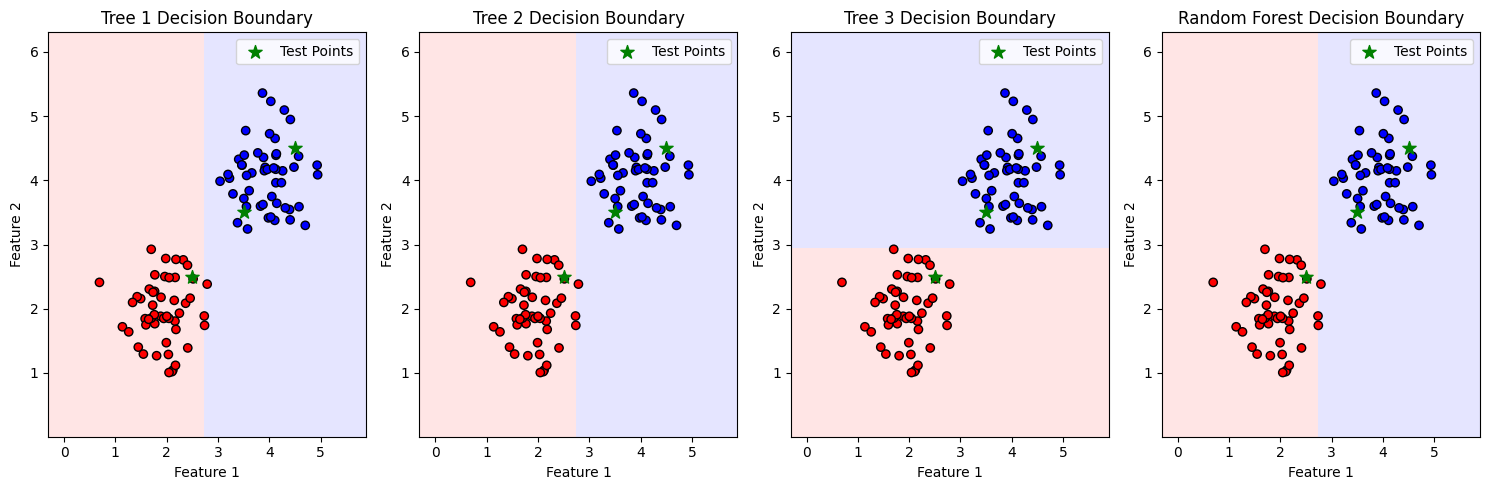

<Figure size 800x600 with 0 Axes>

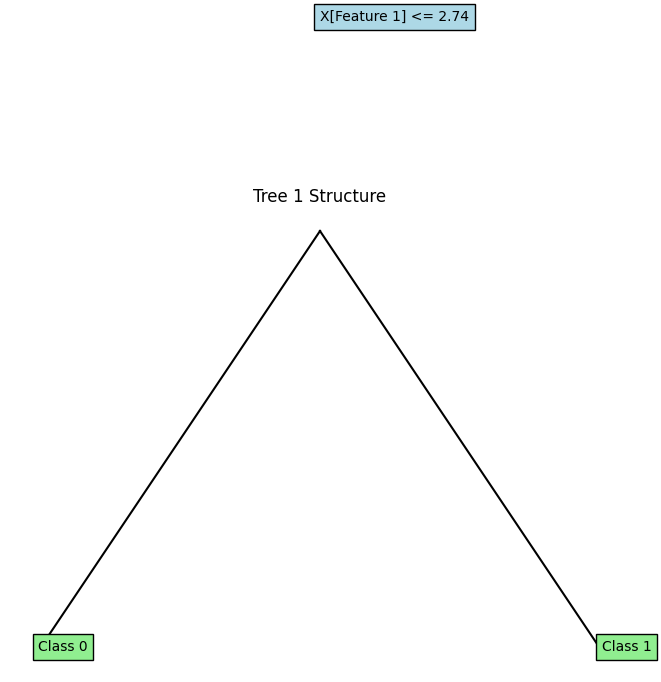

<Figure size 800x600 with 0 Axes>

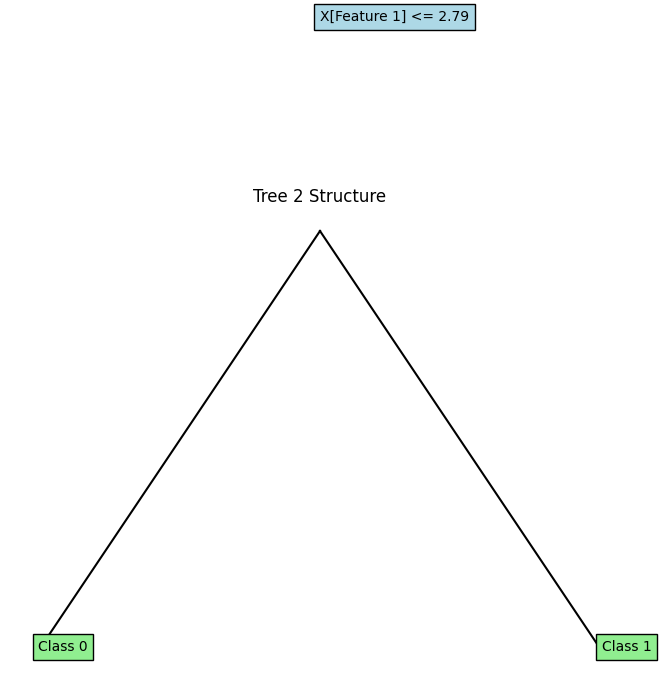

<Figure size 800x600 with 0 Axes>

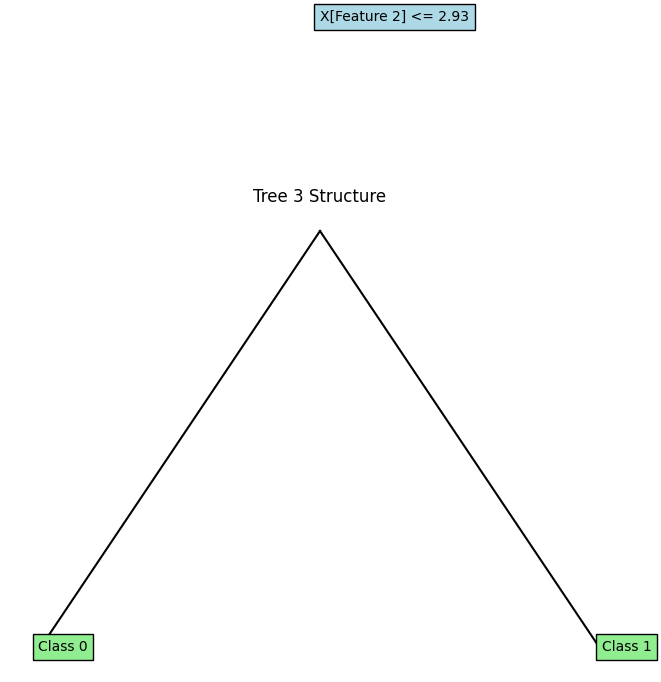

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from collections import Counter
import uuid

# Decision Tree Node
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

# Decision Tree Implementation
class DecisionTree:
    def __init__(self, max_depth=3, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def fit(self, X, y, feature_indices):
        self.feature_indices = feature_indices
        self.root = self._grow_tree(X, y, depth=0)

    def _grow_tree(self, X, y, depth):
        n_samples, n_features = X.shape
        if (depth >= self.max_depth or n_samples < self.min_samples_split or len(np.unique(y)) == 1):
            return Node(value=Counter(y).most_common(1)[0][0])

        best_feature, best_threshold = self._best_split(X, y)
        if best_feature is None:
            return Node(value=Counter(y).most_common(1)[0][0])

        left_idx = X[:, best_feature] <= best_threshold
        right_idx = ~left_idx

        left = self._grow_tree(X[left_idx], y[left_idx], depth + 1)
        right = self._grow_tree(X[right_idx], y[right_idx], depth + 1)
        return Node(best_feature, best_threshold, left, right)

    def _best_split(self, X, y):
        best_gain = -1
        best_feature, best_threshold = None, None
        n_samples, n_features = X.shape

        for feature in self.feature_indices:
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_idx = X[:, feature] <= threshold
                right_idx = ~left_idx
                if sum(left_idx) == 0 or sum(right_idx) == 0:
                    continue
                gain = self._information_gain(y, left_idx, right_idx)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold
        return best_feature, best_threshold

    def _information_gain(self, y, left_idx, right_idx):
        parent_entropy = self._entropy(y)
        n = len(y)
        n_l, n_r = sum(left_idx), sum(right_idx)
        if n_l == 0 or n_r == 0:
            return 0
        child_entropy = (n_l / n) * self._entropy(y[left_idx]) + (n_r / n) * self._entropy(y[right_idx])
        return parent_entropy - child_entropy

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log2(p) for p in ps if p > 0])

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

# Random Forest Implementation
class RandomForest:
    def __init__(self, n_trees=3, max_depth=3, min_samples_split=2, n_features=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_features = n_features
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        n_samples, n_features = X.shape
        if self.n_features is None:
            self.n_features = int(np.sqrt(n_features))

        for _ in range(self.n_trees):
            # Bootstrap sampling
            idx = np.random.choice(n_samples, n_samples, replace=True)
            X_sample, y_sample = X[idx], y[idx]
            feature_indices = np.random.choice(n_features, self.n_features, replace=False)
            tree = DecisionTree(self.max_depth, self.min_samples_split)
            tree.fit(X_sample, y_sample, feature_indices)
            self.trees.append((tree, feature_indices))

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree, _ in self.trees])
        return np.apply_along_axis(lambda x: Counter(x).most_common(1)[0][0], axis=0, arr=predictions)

# Function to plot decision boundary
def plot_decision_boundary(X, y, model, title, test_points=None):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']))
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=ListedColormap(['#FF0000', '#0000FF']))
    if test_points is not None:
        plt.scatter(test_points[:, 0], test_points[:, 1], c='green', s=100, marker='*', label='Test Points')
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()

# Function to plot tree structure
def plot_tree(node, depth=0, pos=(0, 0), ax=None, feature_names=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    if node.value is not None:
        ax.text(pos[0], pos[1], f"Class {node.value}", bbox=dict(facecolor='lightgreen', edgecolor='black'))
        return
    ax.text(pos[0], pos[1], f"X[{feature_names[node.feature]}] <= {node.threshold:.2f}",
            bbox=dict(facecolor='lightblue', edgecolor='black'))
    if node.left:
        ax.plot([pos[0], pos[0] - 0.3/(depth+1)], [pos[1] - 0.1, pos[1] - 0.3], 'k-')
        plot_tree(node.left, depth + 1, (pos[0] - 0.3/(depth+1), pos[1] - 0.3), ax, feature_names)
    if node.right:
        ax.plot([pos[0], pos[0] + 0.3/(depth+1)], [pos[1] - 0.1, pos[1] - 0.3], 'k-')
        plot_tree(node.right, depth + 1, (pos[0] + 0.3/(depth+1), pos[1] - 0.3), ax, feature_names)

# Main execution
if __name__ == "__main__":
    # Generate synthetic data
    np.random.seed(42)
    X = np.vstack([
        np.random.normal([2, 2], 0.5, (50, 2)),
        np.random.normal([4, 4], 0.5, (50, 2))
    ])
    y = np.array([0] * 50 + [1] * 50)
    test_points = np.array([[2.5, 2.5], [3.5, 3.5], [4.5, 4.5]])

    # Train Random Forest
    rf = RandomForest(n_trees=3, max_depth=2, n_features=2)
    rf.fit(X, y)

    # Plot decision boundaries for each tree and the ensemble
    plt.figure(figsize=(15, 5))
    for i, (tree, feature_indices) in enumerate(rf.trees):
        plt.subplot(1, 4, i + 1)
        plot_decision_boundary(X, y, tree, f"Tree {i+1} Decision Boundary", test_points)
    plt.subplot(1, 4, 4)
    plot_decision_boundary(X, y, rf, "Random Forest Decision Boundary", test_points)
    plt.tight_layout()
    plt.savefig('decision_boundaries.png')

    # Plot tree structures
    for i, (tree, feature_indices) in enumerate(rf.trees):
        plt.figure(figsize=(8, 6))
        plot_tree(tree.root, feature_names=['Feature 1', 'Feature 2'])
        plt.title(f"Tree {i+1} Structure")
        plt.axis('off')
        plt.savefig(f'tree_structure_{i+1}.png')

    # Predict and print results for test points
    predictions = rf.predict(test_points)
    print("Test Point Predictions:")
    for i, point in enumerate(test_points):
        print(f"Point {point}: Predicted Class {predictions[i]}")

pip install xgboost

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from IPython.display import HTML

# Generate synthetic 2D classification dataset
X, y = make_moons(n_samples=200, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
n_samples = len(y_train)

# Create meshgrid for decision boundary visualization
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
X_grid = np.c_[xx.ravel(), yy.ravel()]

# Random Forest setup
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_probabilities = []
for k in range(1, 101):
    trees = rf.estimators_[:k]
    probs = np.mean([tree.predict_proba(X_grid)[:, 1] for tree in trees], axis=0)
    rf_probabilities.append(probs)

# XGBoost setup
xgb = XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
xgb.fit(X_train, y_train)
xgb_probabilities = []
for k in range(1, 101):
    xgb_temp = XGBClassifier(n_estimators=k, random_state=42, eval_metric='logloss')
    xgb_temp.fit(X_train, y_train)
    probs = xgb_temp.predict_proba(X_grid)[:, 1]
    xgb_probabilities.append(probs)

# AdaBoost with Weighted Errors implementation
def adaboost(X, y, n_estimators):
    y_ab = 2 * y - 1  # Convert labels to -1 and 1
    w = np.ones(len(y)) / len(y)
    models, alphas, weights_list = [], [], [w.copy()]
    for _ in range(n_estimators):
        clf = DecisionTreeClassifier(max_depth=1)
        clf.fit(X, y_ab, sample_weight=w)
        pred = clf.predict(X)
        err = np.sum(w * (pred != y_ab)) / np.sum(w)
        alpha = 0.5 * np.log((1 - err) / err)
        w = w * np.exp(-alpha * y_ab * pred)
        w /= np.sum(w)
        models.append(clf)
        alphas.append(alpha)
        weights_list.append(w.copy())
    return models, alphas, weights_list

adaboost_models, adaboost_alphas, weights_list = adaboost(X_train, y_train, 100)
h_m = [model.predict(X_grid) for model in adaboost_models]
adaboost_probabilities = []
S = np.zeros(len(X_grid))
for alpha, h in zip(adaboost_alphas, h_m):
    S += alpha * h
    prob = 1 / (1 + np.exp(-S))
    adaboost_probabilities.append(prob)

# Set up the figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].set_title('Random Forest')
axes[1].set_title('XGBoost')
axes[2].set_title('AdaBoost with Weighted Errors')

# Initial plots
pcm_rf = axes[0].pcolormesh(xx, yy, rf_probabilities[0].reshape(xx.shape), cmap='RdBu', shading='auto')
pcm_xgb = axes[1].pcolormesh(xx, yy, xgb_probabilities[0].reshape(xx.shape), cmap='RdBu', shading='auto')
pcm_ab = axes[2].pcolormesh(xx, yy, adaboost_probabilities[0].reshape(xx.shape), cmap='RdBu', shading='auto')

scatter_rf = axes[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='RdBu', s=20, edgecolor='k')
scatter_xgb = axes[1].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='RdBu', s=20, edgecolor='k')
s_ab = 50 * weights_list[0] * n_samples
scatter_ab = axes[2].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='RdBu', s=s_ab, edgecolor='k')

# Update function for animation
def update(k):
    pcm_rf.set_array(rf_probabilities[k].ravel())
    pcm_xgb.set_array(xgb_probabilities[k].ravel())
    pcm_ab.set_array(adaboost_probabilities[k].ravel())
    s_ab = 50 * weights_list[k + 1] * n_samples
    scatter_ab.set_sizes(s_ab)
    fig.suptitle(f'Number of Estimators: {k + 1}')
    return pcm_rf, pcm_xgb, pcm_ab, scatter_ab

# Create and display animation
anim = FuncAnimation(fig, update, frames=100, interval=200, blit=False)
plt.close()  # Prevent static display of the initial frame
HTML(anim.to_jshtml())

XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ["dlopen(/Volumes/MacSSD/Machine Learning for Business/.venv/lib/python3.10/site-packages/xgboost/lib/libxgboost.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib\n  Referenced from: <8E129FE8-EF1C-38EA-A9CF-202782564052> /Volumes/MacSSD/Machine Learning for Business/.venv/lib/python3.10/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: tried: '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file)"]


⸻

Ensemble Methods

⸻

1. Bootstrap Aggregating (Bagging)

Bagging builds multiple models on bootstrapped (resampled) subsets of the data and aggregates predictions:
	•	Classification: Majority vote
	•	Regression: Mean

Goal: Reduce variance by averaging many high-variance models (e.g., deep decision trees).

⸻

2. Random Forests and Feature Subsampling

Random Forest = Bagging + Random Feature Subsets
	•	At each split, only a random subset of features is considered.
	•	Reduces correlation between trees.

Advantages:
	•	Low variance.
	•	Handles high-dimensional data.
	•	Good generalization.

⸻

3. Boosting: AdaBoost, Gradient Boosting

AdaBoost (Adaptive Boosting)

Builds models sequentially, each correcting the errors of the previous one.
	•	Maintain weights over training samples.
	•	Misclassified samples get higher weights.
	•	Weak learners (e.g., shallow trees) are combined into a strong learner.

Final classifier:

$$
H(x) = \text{sign} \left( \sum_{t=1}^T \alpha_t h_t(x) \right)
$$

Where:
	•	$h_t(x)$: weak learner
	•	$\alpha_t = \frac{1}{2} \ln \left( \frac{1 - \epsilon_t}{\epsilon_t} \right)$
	•	$\epsilon_t$: weighted error

⸻

Gradient Boosting
	•	Learns by fitting to the residuals of the previous model.
	•	Optimizes a loss function using gradient descent in function space.

⸻

4. Python: AdaBoost with Weighted Errors (From Scratch)

import numpy as np
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

class AdaBoost:
    def __init__(self, n_estimators=10):
        self.n_estimators = n_estimators
        self.alphas = []
        self.models = []

    def fit(self, X, y):
        n_samples, _ = X.shape
        w = np.ones(n_samples) / n_samples

        for _ in range(self.n_estimators):
            clf = DecisionTreeClassifier(max_depth=1)
            clf.fit(X, y, sample_weight=w)
            y_pred = clf.predict(X)

            err = np.sum(w * (y_pred != y)) / np.sum(w)
            alpha = 0.5 * np.log((1 - err) / (err + 1e-10))

            w *= np.exp(-alpha * y * y_pred)
            w /= np.sum(w)

            self.models.append(clf)
            self.alphas.append(alpha)

    def predict(self, X):
        pred = sum(alpha * clf.predict(X) for alpha, clf in zip(self.alphas, self.models))
        return np.sign(pred)

# Example usage
X, y = make_classification(n_samples=500, n_features=10)
y = 2 * y - 1  # Convert to {-1, 1}

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

ab = AdaBoost(n_estimators=20)
ab.fit(X_train, y_train)
y_pred = ab.predict(X_test)

print("AdaBoost Accuracy:", accuracy_score(y_test, y_pred))

⸻
